<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>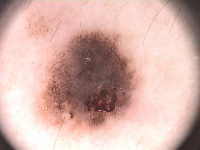</td><td>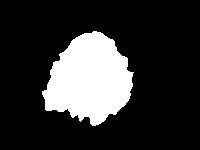</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print('Loaded %d images' % len(X))

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

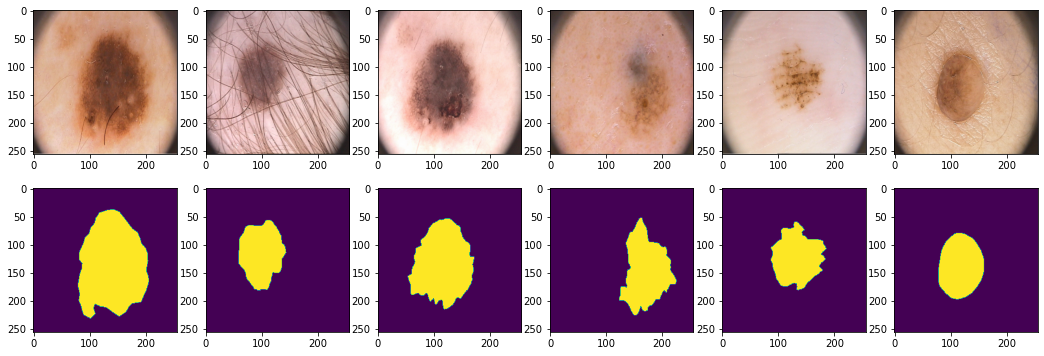

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [18, 6]

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [5]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])


In [6]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [7]:
from torch.utils.data import DataLoader
batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])), batch_size=batch_size, shuffle=True)

In [8]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

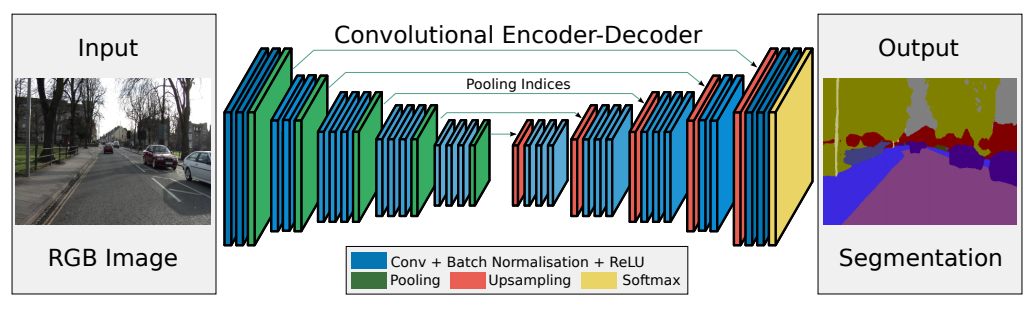

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time


In [10]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        # self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16
        self.pool3 = nn.MaxPool2d(2, 2, padding=0)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [11]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [12]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [13]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    loss_values = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
    
            
        loss_values.append(float(avg_loss))

        toc = time()
        print(' - loss: %f' % avg_loss)

        
        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_val.to(device))).detach().cpu()
        clear_output(wait=True)

        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            
            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Real_Segment')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return loss_values

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [14]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [15]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.round(nn.Sigmoid()(model(X_batch.cuda()))) #F.sigmoid(model(X_batch.to(device))).to(device)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [29]:
torch.cuda.empty_cache()
model = SegNet().to(device)
summary(model, (3, 256, 256)).total_params

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 256, 256]        1,792
├─MaxPool2d: 1-2                         [-1, 64, 128, 128]        --
├─Conv2d: 1-3                            [-1, 64, 128, 128]        36,928
├─MaxPool2d: 1-4                         [-1, 64, 64, 64]          --
├─Conv2d: 1-5                            [-1, 64, 64, 64]          36,928
├─MaxPool2d: 1-6                         [-1, 64, 32, 32]          --
├─Conv2d: 1-7                            [-1, 64, 32, 32]          36,928
├─MaxPool2d: 1-8                         [-1, 64, 16, 16]          --
├─Conv2d: 1-9                            [-1, 64, 16, 16]          36,928
├─Upsample: 1-10                         [-1, 64, 32, 32]          --
├─Conv2d: 1-11                           [-1, 64, 32, 32]          36,928
├─Upsample: 1-12                         [-1, 64, 64, 64]          --
├─Conv2d: 1-13                           [-1, 64, 64, 64]     

260865

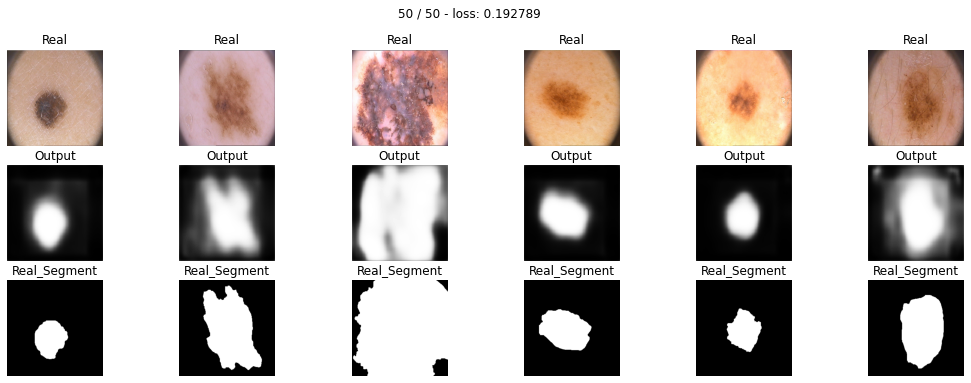

In [30]:
loss_model = train(model, optim.Adam(model.parameters(), 0.0001), bce_loss, 50, data_tr, data_val)

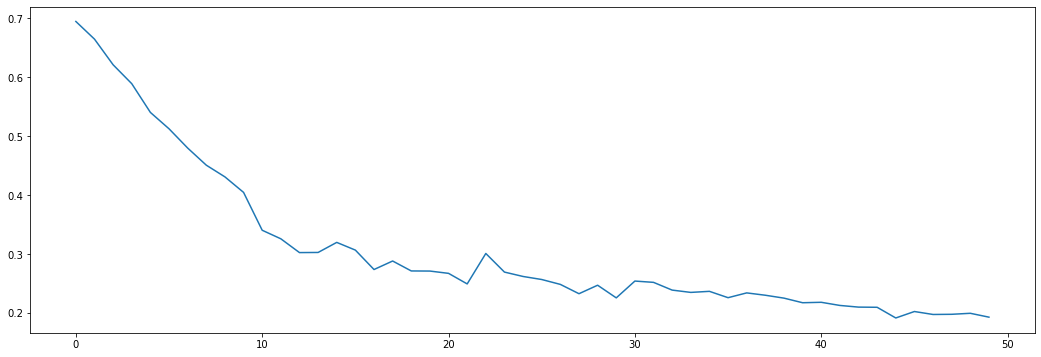

In [31]:
plt.plot(loss_model)

In [37]:
import copy

# сохранить веса нашей нейросети model
model_segnet_bce = copy.deepcopy(model.state_dict())
torch.save(model_segnet_bce, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_segnet_bce.pth")

In [38]:
model = SegNet().to(device)
model.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_segnet_bce.pth"))

<All keys matched successfully>

In [39]:
score_model(model, iou_pytorch, data_ts)

0.6111111409134335

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [40]:
def dice_loss(y_real, y_pred, smooth=1):
    inputs = F.sigmoid(y_pred)
    
    inputs = inputs.view(-1)
    targets = y_real.view(-1)
    
    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    
    return 1 - dice 

Проводим тестирование:

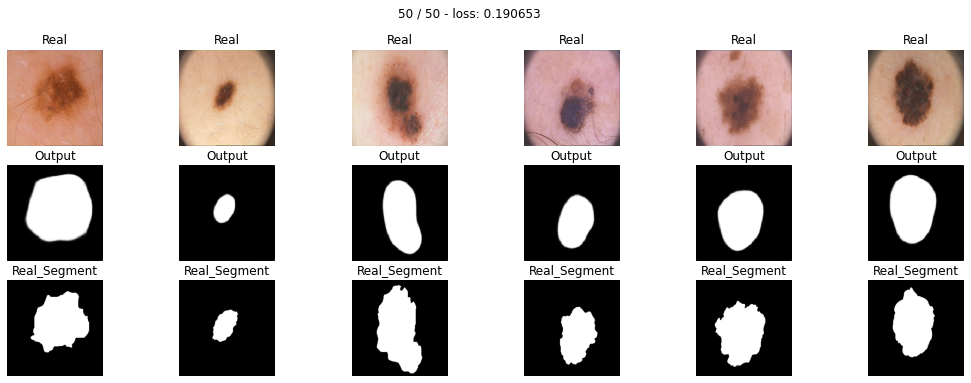

In [41]:
torch.cuda.empty_cache()
model_dice = SegNet().to(device)
loss_dice = train(model_dice , optim.Adam(model_dice.parameters(), 0.0001), dice_loss, 50, data_tr, data_val)

In [44]:
# сохранить веса нашей нейросети model_dice
model_segnet_dice = copy.deepcopy(model_dice.state_dict())
torch.save(model_segnet_dice, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_segnet_dice.pth")

model_dice = SegNet().to(device)
model_dice.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_segnet_dice.pth"))

<All keys matched successfully>

In [46]:
score_model(model_dice, iou_pytorch, data_ts)

0.49444447623358834

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [47]:
def focal_loss(y_real, y_pred):

  γ = 2
  σy_pred = 1/(1+torch.exp(-y_pred))

  focal = - torch.mean((1 - σy_pred)**γ * y_real * torch.log(σy_pred) + (1-y_real) * torch.log(1-σy_pred)) 

  return(focal)

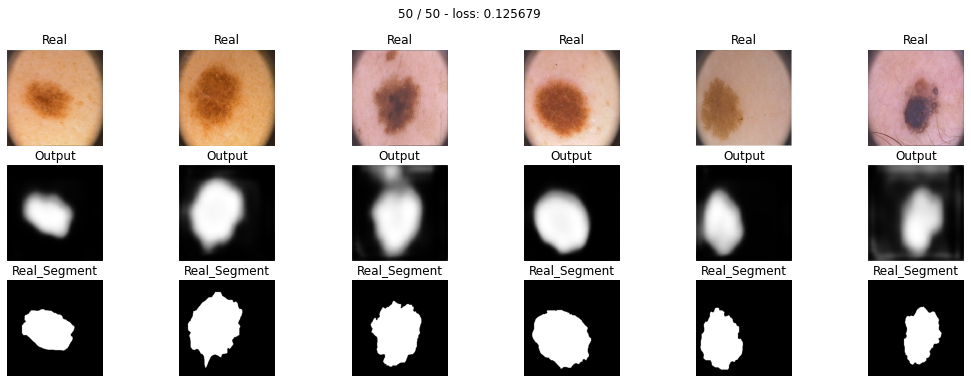

In [50]:
torch.cuda.empty_cache()
model_focal = SegNet().to(device)
loss_focal = train(model_focal, optim.Adam(model_focal.parameters(), 0.0001), focal_loss, 50, data_tr, data_val)

In [54]:
# сохранить веса нашей нейросети model_focal
model_segnet_focal = copy.deepcopy(model_focal.state_dict())
torch.save(model_segnet_focal, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_segnet_focal.pth")

model_focal = SegNet().to(device)
model_focal.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_segnet_focal.pth"))

<All keys matched successfully>

In [55]:
score_model(model_focal, iou_pytorch, data_ts)

0.6407407720883688

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

Используем loss функцию из статьи 
* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

Чем больше наших предварительных знаний мы сможем передать в нейронную сеть, тем лучше. Один из способов введения таких базовых знаний - регуляризация. Регуляризация - это дополнительные члены, добавленные к функции потерь.

**Centered:**
$$\mathcal L_{centered}(y,\hat y) = 1-\sigma(\hat y_{w/2,h/2})$$

**Sparcity:**
$$\mathcal L_{sparcity} = \sigma(\hat y)$$

**Contiguity:**
$$\mathcal L_{contiguity} = \sum_{i,j}|\sigma(\hat y_{i+1,j})-\sigma(\hat y_{i,j})|+\sum_{i,j}|\sigma(\hat y_{i,j+1})-\sigma(\hat y_{i,j})|$$



In [56]:
def bce_total_variation(y_real, y_pred):

    σy_pred = torch.sigmoid(y_pred)
    
    xr = torch.mean(torch.abs(σy_pred[:,:,1:,:] - σy_pred[:,:,:-1,:]))
    yr = torch.mean(torch.abs(σy_pred[:,:,:,1:] - σy_pred[:,:,:,:-1]))


    return bce_loss(y_real, y_pred) + 0.1* (xr + yr)

In [57]:
torch.cuda.empty_cache()

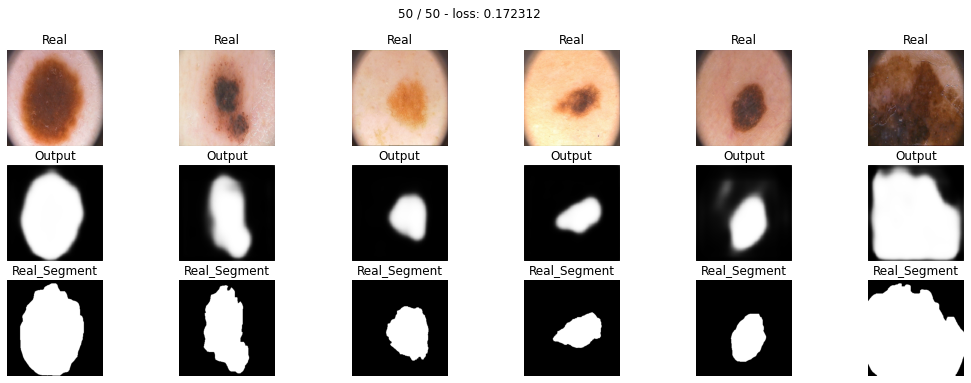

In [58]:
torch.cuda.empty_cache()
model_reg = SegNet().to(device)
loss_reg = train(model_reg, optim.Adam(model_reg.parameters(), 0.0001), bce_total_variation, 50, data_tr, data_val)

In [61]:
# сохранить веса нашей нейросети model_reg
model_segnet_reg = copy.deepcopy(model_reg.state_dict())
torch.save(model_segnet_reg, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_segnet_reg.pth")

model_reg = SegNet().to(device)
model_reg.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_segnet_reg.pth"))

<All keys matched successfully>

In [63]:
score_model(model_reg, iou_pytorch, data_ts)

0.6648148364490933

Многие лоссы есть в *[Loss Function Reference for Keras & PyTorch](https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch)*

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

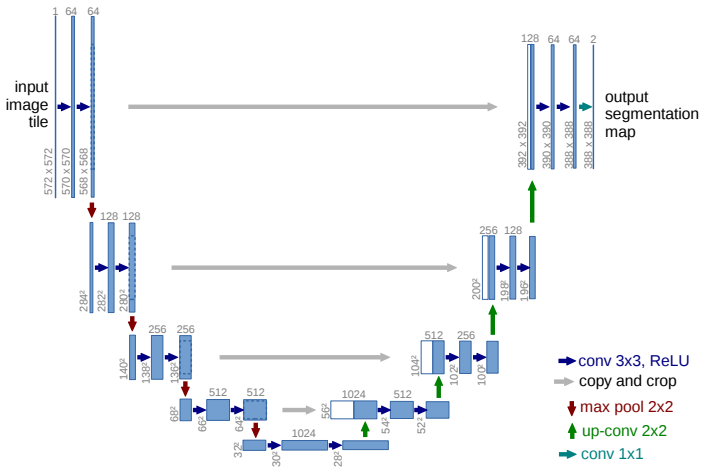

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [67]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1) # same
        self.pool0 = nn.MaxPool2d(2, 2, padding=0)  # 256 -> 128

        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1) # same
        self.pool1 = nn.MaxPool2d(2, 2, padding=0)  # 128 -> 64

        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1) # same
        self.pool2 = nn.MaxPool2d(2, 2, padding=0)  # 64 -> 32
        
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1) # same
        self.pool3 = nn.MaxPool2d(2, 2, padding=0)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1) # same

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1) # 64+64=128 because of skip
        
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1) # 64+64=128 because of skip
        
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1) # 64+64=128 because of skip
        
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1) # 64+64=128 because of skip
        

    def forward(self, x):
        # encoder
        e0s = F.relu(self.enc_conv0(x))
        e0 = self.pool0(e0s)
        
        e1s = F.relu(self.enc_conv1(e0))
        e1 = self.pool1(e1s)
        
        e2s = F.relu(self.enc_conv2(e1))
        e2 = self.pool2(e2s)
        
        e3s = F.relu(self.enc_conv3(e2))
        e3 = self.pool3(e3s)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b),e3s],1)))

        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0),e2s],1)))

        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1),e1s],1)))

        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0s],1))  # no activation

        return d3

In [68]:
torch.cuda.empty_cache()
model_unet = UNet().to(device)
summary(model_unet, (3, 256, 256)).total_params

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 256, 256]        1,792
├─MaxPool2d: 1-2                         [-1, 64, 128, 128]        --
├─Conv2d: 1-3                            [-1, 64, 128, 128]        36,928
├─MaxPool2d: 1-4                         [-1, 64, 64, 64]          --
├─Conv2d: 1-5                            [-1, 64, 64, 64]          36,928
├─MaxPool2d: 1-6                         [-1, 64, 32, 32]          --
├─Conv2d: 1-7                            [-1, 64, 32, 32]          36,928
├─MaxPool2d: 1-8                         [-1, 64, 16, 16]          --
├─Conv2d: 1-9                            [-1, 64, 16, 16]          36,928
├─Upsample: 1-10                         [-1, 64, 32, 32]          --
├─Conv2d: 1-11                           [-1, 64, 32, 32]          73,792
├─Upsample: 1-12                         [-1, 64, 64, 64]          --
├─Conv2d: 1-13                           [-1, 64, 64, 64]     

372033

## U-Net c BCE Loss

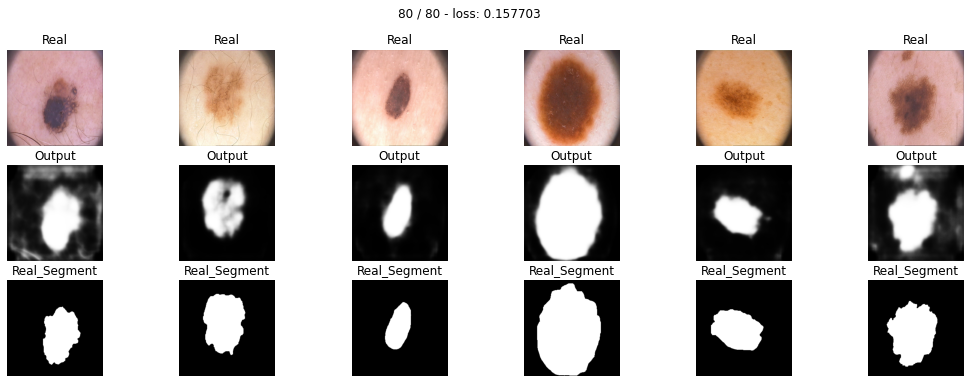

In [69]:
torch.cuda.empty_cache()
loss_unet = train(model_unet, optim.Adam(model_unet.parameters(), 0.0001), bce_loss, 80, data_tr, data_val)

In [72]:
# сохранить веса нашей нейросети model_unet_bce
model_unet_bce = copy.deepcopy(model_unet.state_dict())
torch.save(model_unet_bce, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet_bce.pth")

model_unet = UNet().to(device)
model_unet.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet_bce.pth"))

<All keys matched successfully>

In [74]:
score_model(model_unet, iou_pytorch, data_ts)

0.7000000476837158

## U-Net c Dice Loss

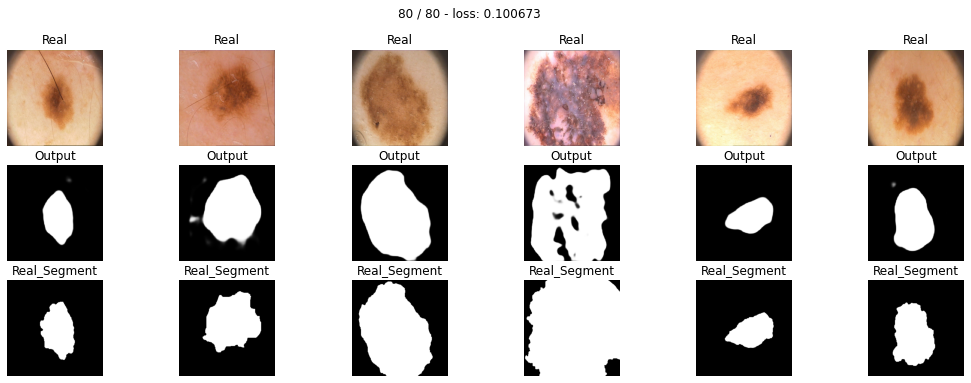

In [75]:
torch.cuda.empty_cache()
model_unet_dice = UNet().to(device)
loss_unet_dice = train(model_unet_dice, optim.Adam(model_unet_dice.parameters(), 0.0001), dice_loss, 80, data_tr, data_val)

In [77]:
# сохранить веса нашей нейросети model_unet_dice
model_unet_dice_save = copy.deepcopy(model_unet_dice.state_dict())
torch.save(model_unet_dice_save, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet_dice.pth")

model_unet_dice = UNet().to(device)
model_unet_dice.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet_dice.pth"))

<All keys matched successfully>

In [80]:
score_model(model_unet_dice, iou_pytorch, data_ts)

0.6981481777297126

## U-Net c Focal Loss

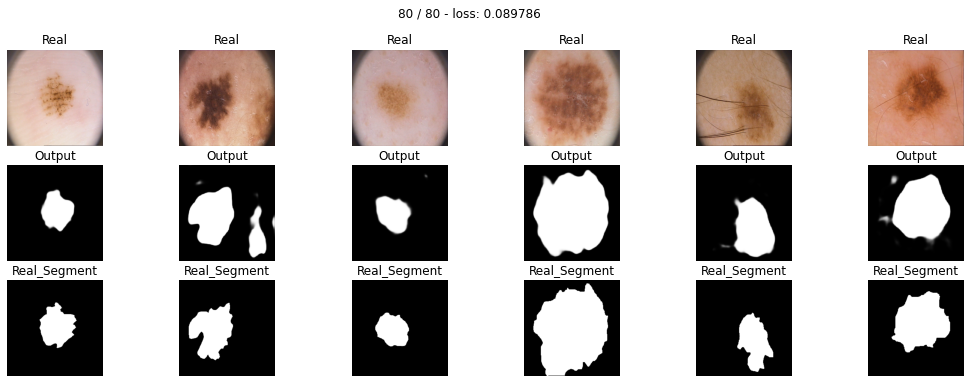

In [81]:
torch.cuda.empty_cache()
model_unet_focal = UNet().to(device)
loss_unet_focal = train(model_unet_focal, optim.Adam(model_unet_focal.parameters(), 0.0001), focal_loss, 80, data_tr, data_val)

In [86]:
# сохранить веса нашей нейросети model_unet_dice
model_unet_focal_save = copy.deepcopy(model_unet_focal.state_dict())
torch.save(model_unet_focal_save, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet_focal.pth")

model_unet_focal = UNet().to(device)
model_unet_focal.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet_focal.pth"))

<All keys matched successfully>

In [87]:
score_model(model_unet_focal, iou_pytorch, data_ts)

0.7074074347813925

## U-Net c Reg Loss

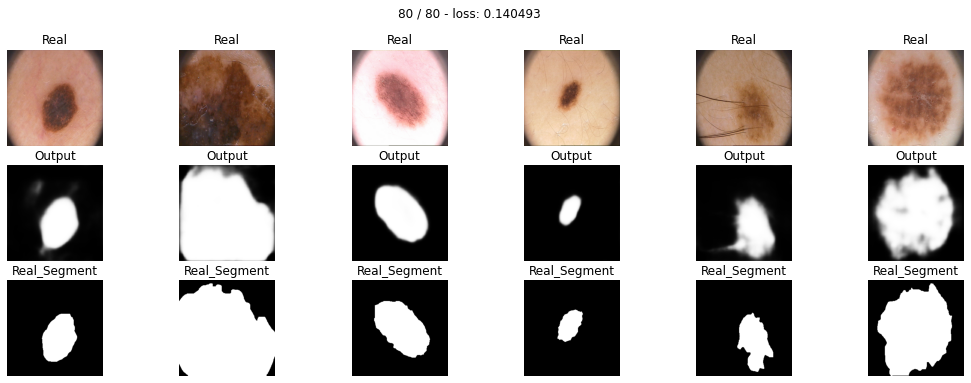

In [88]:
torch.cuda.empty_cache()
model_unet_reg = UNet().to(device)
loss_unet_reg = train(model_unet_reg, optim.Adam(model_unet_reg.parameters(), 0.0001), bce_total_variation, 80, data_tr, data_val)

In [90]:
# сохранить веса нашей нейросети model_unet_dice
model_unet_reg_save = copy.deepcopy(model_unet_reg.state_dict())
torch.save(model_unet_reg_save, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet_reg.pth")

model_unet_reg = UNet().to(device)
model_unet_reg.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet_reg.pth"))

<All keys matched successfully>

In [89]:
score_model(model_unet_reg, iou_pytorch, data_ts)

0.6629629996087816

## U-Net 2

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [95]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1) # same
        self.pool0 = nn.Conv2d(64, 64, 2, padding=0, stride = 2)   # 256 -> 128


        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1) # same
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride = 2)  # 128 -> 64


        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1) # same
        self.pool2 = nn.Conv2d(64, 64, 2, padding=0, stride = 2)  # 64 -> 32

        
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1) # same
        self.pool3 = nn.Conv2d(64, 64, 2, padding=0, stride = 2)  # 32 -> 16


        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1) # same

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(64, 64, 2, stride= 2, padding= 0, output_padding= 0) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1) # 64+64=128 because of skip
        
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride = 2, padding= 0, output_padding= 0) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1) # 64+64=128 because of skip
        
        self.upsample2 = nn.ConvTranspose2d(64, 64, 2, stride= 2, padding= 0, output_padding= 0) # 64 -> 128
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1) # 64+64=128 because of skip
        
        self.upsample3 = nn.ConvTranspose2d(64, 64, 2, stride= 2, padding= 0, output_padding= 0) # 128 -> 256
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1) # 64+64=128 because of skip
        

    def forward(self, x):
        # encoder
        e0s = F.relu(self.enc_conv0(x))
        e0 = self.pool0(e0s)
        
        e1s = F.relu(self.enc_conv1(e0))
        e1 = self.pool1(e1s)
        
        e2s = F.relu(self.enc_conv2(e1))
        e2 = self.pool2(e2s)
        
        e3s = F.relu(self.enc_conv3(e2))
        e3 = self.pool3(e3s)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b),e3s],1)))

        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0),e2s],1)))

        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1),e1s],1)))

        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0s],1))  # no activation

        return d3

In [97]:
torch.cuda.empty_cache()
model_unet2 = UNet2().to(device)
summary(model, (3, 256, 256)).total_params

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 256, 256]        1,792
├─MaxPool2d: 1-2                         [-1, 64, 128, 128]        --
├─Conv2d: 1-3                            [-1, 64, 128, 128]        36,928
├─MaxPool2d: 1-4                         [-1, 64, 64, 64]          --
├─Conv2d: 1-5                            [-1, 64, 64, 64]          36,928
├─MaxPool2d: 1-6                         [-1, 64, 32, 32]          --
├─Conv2d: 1-7                            [-1, 64, 32, 32]          36,928
├─MaxPool2d: 1-8                         [-1, 64, 16, 16]          --
├─Conv2d: 1-9                            [-1, 64, 16, 16]          36,928
├─Upsample: 1-10                         [-1, 64, 32, 32]          --
├─Conv2d: 1-11                           [-1, 64, 32, 32]          36,928
├─Upsample: 1-12                         [-1, 64, 64, 64]          --
├─Conv2d: 1-13                           [-1, 64, 64, 64]     

260865

## U-Net 2 c BCE Loss

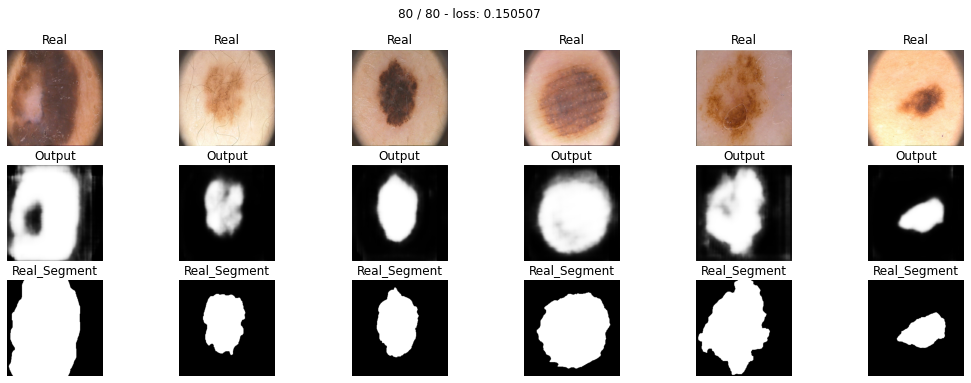

In [98]:
torch.cuda.empty_cache()
loss_unet2 = train(model_unet2, optim.Adam(model_unet2.parameters(), 0.0001), bce_loss, 80, data_tr, data_val)

In [100]:
# сохранить веса нашей нейросети model_unet2_bce
model_unet2_bce = copy.deepcopy(model_unet2.state_dict())
torch.save(model_unet2_bce, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet2_bce.pth")

model_unet2 = UNet2().to(device)
model_unet2.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet2_bce.pth"))

<All keys matched successfully>

In [101]:
score_model(model_unet2, iou_pytorch, data_ts)

0.7055555714501275

## U-Net 2 c Dice Loss

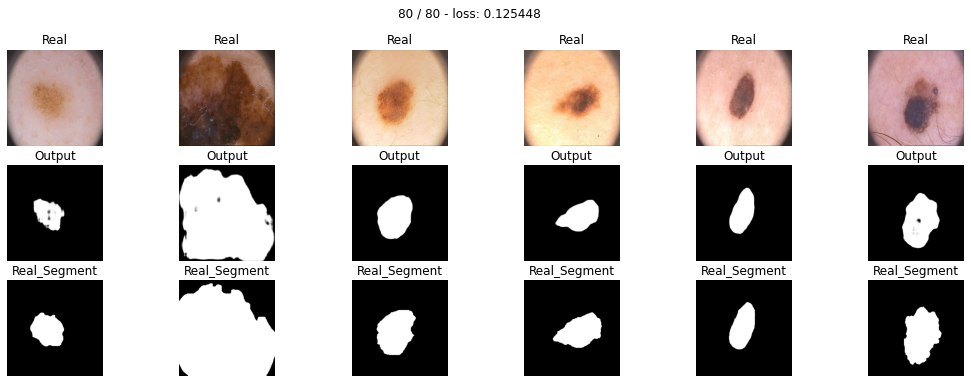

In [129]:
torch.cuda.empty_cache()
model_unet2_dice = UNet2().to(device)
loss_unet2_dice = train(model_unet2_dice, optim.Adam(model_unet2_dice.parameters(), 0.0001), dice_loss, 80, data_tr, data_val)

In [130]:
# сохранить веса нашей нейросети model_unet2_dice
model_unet2_dice_save = copy.deepcopy(model_unet2_dice.state_dict())
torch.save(model_unet2_dice_save, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet2_dice.pth")

model_unet2_dice = UNet2().to(device)
model_unet2_dice.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet2_dice.pth"))

<All keys matched successfully>

In [106]:
score_model(model_unet2_dice, iou_pytorch, data_ts)

0.6611111495229933

## U-Net 2 c Focal Loss

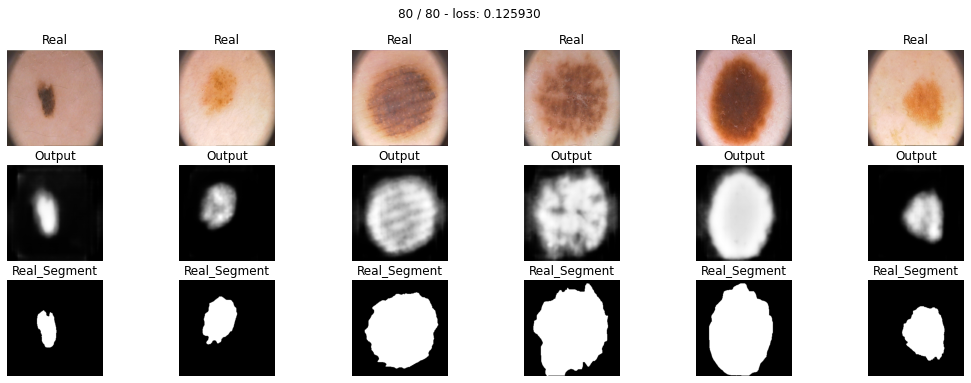

In [107]:
torch.cuda.empty_cache()
model_unet2_focal = UNet2().to(device)
loss_unet2_focal = train(model_unet2_focal, optim.Adam(model_unet2_focal.parameters(), 0.0001), focal_loss, 80, data_tr, data_val)

In [109]:
# сохранить веса нашей нейросети model_unet_dice
model_unet2_focal_save = copy.deepcopy(model_unet2_focal.state_dict())
torch.save(model_unet2_focal_save, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet2_focal.pth")

model_unet2_focal = UNet2().to(device)
model_unet2_focal.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet2_focal.pth"))

<All keys matched successfully>

In [112]:
score_model(model_unet2_focal, iou_pytorch, data_ts)

0.6148148443963792

## U-Net 2 c Reg Loss

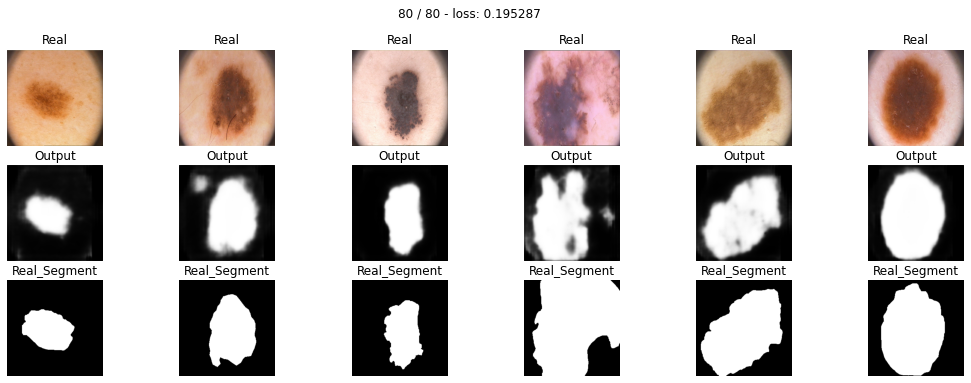

In [121]:
torch.cuda.empty_cache()
model_unet2_reg = UNet2().to(device)
loss_unet2_reg = train(model_unet2_reg, optim.Adam(model_unet2_reg.parameters(), 0.0001), bce_total_variation, 80, data_tr, data_val)

In [123]:
# сохранить веса нашей нейросети model_unet_dice
model_unet2_reg_save = copy.deepcopy(model_unet2_reg.state_dict())
torch.save(model_unet2_reg_save, "C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet2_reg.pth")

model_unet2_reg = UNet2().to(device)
model_unet2_reg.load_state_dict(torch.load("C:/Users/Arcry/SkillBox/Deep_Learning_MFTI/Homeworks/models/model_unet2_reg.pth"))

<All keys matched successfully>

In [127]:
score_model(model_unet2_reg, iou_pytorch, data_ts)

0.6759259700775146

# Отчет (6 баллов): 




Построим зависимости лоссов от эпох для нейросети SegNet.

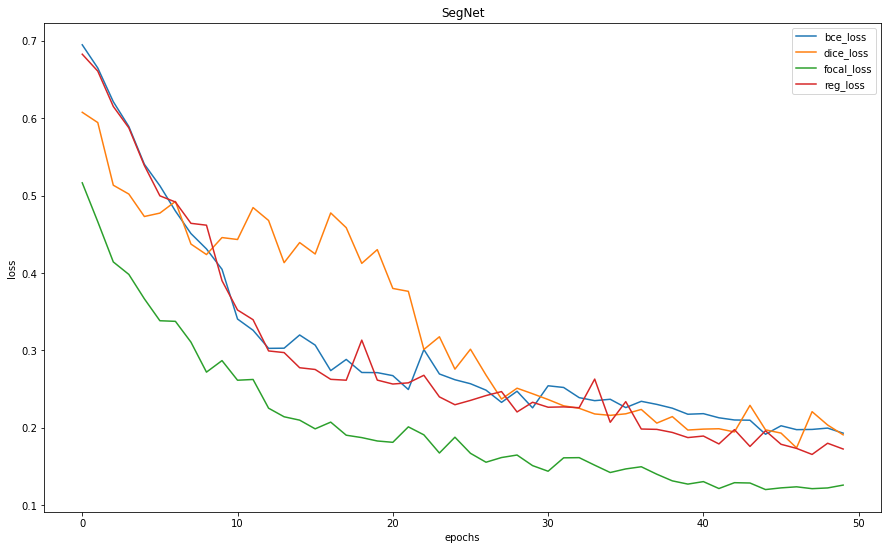

In [136]:
plt.figure(figsize=(15, 9))
plt.plot(loss_model, label="bce_loss")
plt.plot(loss_dice, label="dice_loss")
plt.plot(loss_focal, label="focal_loss")
plt.plot(loss_reg, label="reg_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('SegNet')
plt.show()

In [138]:
print(f'SegNet(BCE loss) score: - val: {score_model(model, iou_pytorch, data_val)} - test: {score_model(model, iou_pytorch, data_ts)}')
print(f'SegNet(Dice loss) score: - val: {score_model(model_dice, iou_pytorch, data_val)} - test: {score_model(model_dice, iou_pytorch, data_ts)}')
print(f'SegNet(Focal loss) score: - val: {score_model(model_focal, iou_pytorch, data_val)} - test: {score_model(model_focal, iou_pytorch, data_ts)}')
print(f'SegNet(Reg loss) score: - val: {score_model(model_reg, iou_pytorch, data_val)} - test: {score_model(model_reg, iou_pytorch, data_ts)}')

SegNet(BCE loss) score: - val: 0.562962982389662 - test: 0.5962963236702813
SegNet(Dice loss) score: - val: 0.45000001622570884 - test: 0.4907407561937968
SegNet(Focal loss) score: - val: 0.6685185465547774 - test: 0.6481481790542603
SegNet(Reg loss) score: - val: 0.6796296503808763 - test: 0.6648148563173082


При одинаковых параметрах и количестве эпох наименьший лосс получился у модели с Focal loss.
Лучший результат по метрике IoU у модели с лоссом, использующим регуляризацию(Physiological Inspired Deep Neural Networks for Emotion Recognition". IEEE Access, 6, 53930-53943.)

In [ ]:
Построим зависимости лоссов от эпох для нейросети U-Net.

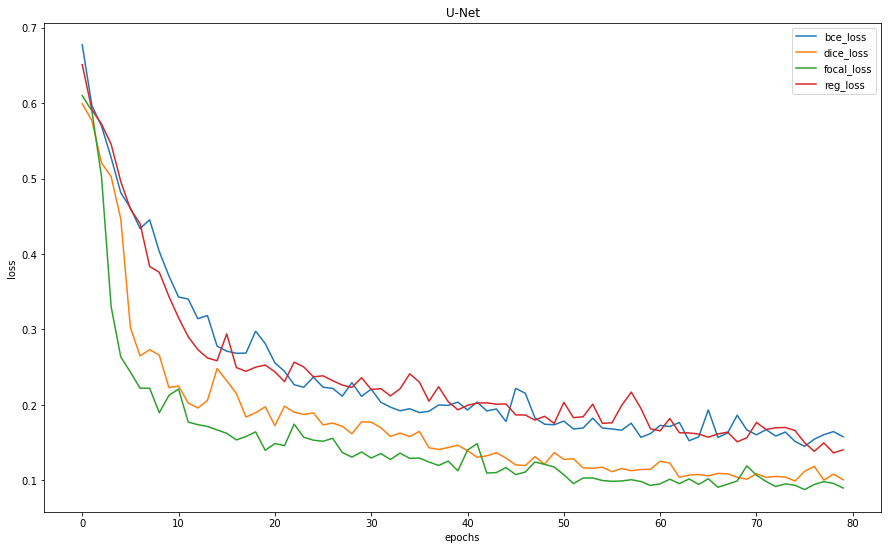

In [144]:
plt.figure(figsize=(15, 9))
plt.plot(loss_unet, label="bce_loss")
plt.plot(loss_unet_dice, label="dice_loss")
plt.plot(loss_unet_focal, label="focal_loss")
plt.plot(loss_unet_reg, label="reg_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('U-Net')
plt.show()

In [145]:
print(f'U-Net(BCE loss) score: - val: {score_model(model_unet, iou_pytorch, data_val)} - test: {score_model(model_unet, iou_pytorch, data_ts)}')
print(f'U-Net(Dice loss) score: - val: {score_model(model_unet_dice, iou_pytorch, data_val)} - test: {score_model(model_unet_dice, iou_pytorch, data_ts)}')
print(f'U-Net(Focal loss) score: - val: {score_model(model_unet_focal, iou_pytorch, data_val)} - test: {score_model(model_unet_focal, iou_pytorch, data_ts)}')
print(f'U-Net(Reg loss) score: - val: {score_model(model_unet_reg, iou_pytorch, data_val)} - test: {score_model(model_unet_reg, iou_pytorch, data_ts)}')

U-Net(BCE loss) score: - val: 0.7518518765767416 - test: 0.6777778069178263
U-Net(Dice loss) score: - val: 0.7092592914899191 - test: 0.6722222533490922
U-Net(Focal loss) score: - val: 0.7407407760620117 - test: 0.6666666997803582
U-Net(Reg loss) score: - val: 0.746296332942115 - test: 0.7037037147416009


При одинаковых параметрах и количестве эпох наименьший лосс получился у модели с Focal loss.
Лучший результат по метрике IoU у модели с лоссом, использующим регуляризацию(Physiological Inspired Deep Neural Networks for Emotion Recognition". IEEE Access, 6, 53930-53943.)

Построим зависимости лоссов от эпох для нейросети U-Net 2.

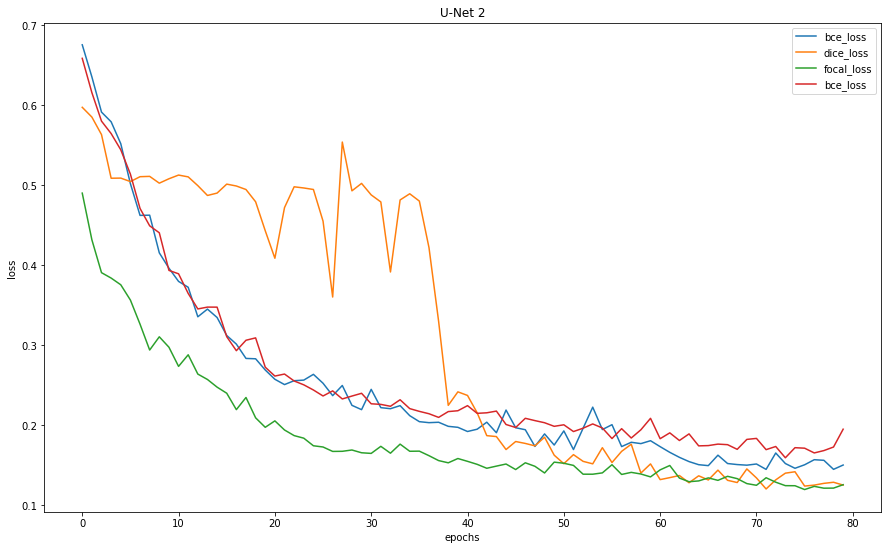

In [147]:
plt.figure(figsize=(15, 9))
plt.plot(loss_unet2, label="bce_loss")
plt.plot(loss_unet2_dice, label="dice_loss")
plt.plot(loss_unet2_focal, label="focal_loss")
plt.plot(loss_unet2_reg, label="bce_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('U-Net 2')
plt.show()

In [150]:
print(f'U-Net 2(BCE loss) score: - val: {score_model(model_unet2, iou_pytorch, data_val)} - test: {score_model(model_unet2, iou_pytorch, data_ts)}')
print(f'U-Net 2(Dice loss) score: - val: {score_model(model_unet2_dice, iou_pytorch, data_val)} - test: {score_model(model_unet2_dice, iou_pytorch, data_ts)}')
print(f'U-Net 2(Focal loss) score: - val: {score_model(model_unet2_focal, iou_pytorch, data_val)} - test: {score_model(model_unet2_focal, iou_pytorch, data_ts)}')
print(f'U-Net 2(Reg loss) score: - val: {score_model(model_unet2_reg, iou_pytorch, data_val)} - test: {score_model(model_unet2_reg, iou_pytorch, data_ts)}')

U-Net 2(BCE loss) score: - val: 0.7259259621302286 - test: 0.694444477558136
U-Net 2(Dice loss) score: - val: 0.6222222381167941 - test: 0.5425926148891449
U-Net 2(Focal loss) score: - val: 0.6777778069178263 - test: 0.6000000105963813
U-Net 2(Reg loss) score: - val: 0.7518518831994798 - test: 0.6574074394173093


При одинаковых параметрах и количестве эпох наименьший лосс получился у модели с Focal loss.
Лучший результат по метрике IoU у модели с BCE loss.

**Наилучший результат Score = 0.7 показала модель U-Net с функцией потерь, использующей регуляризацию.**